# A/B-тест системы рекомендаций

Компания проводит A/B-тест. Группа A - контрольная, а группа B пользуется новой платежной воронкой.  
В моем распоряжении набор данных с действиями пользоватетелей, расписание маркетинговых мероприятияй, набор с новыми пользователями и информация о группах пользователей.  

**Цель:** провести оценку результатов A/B-теста.  

Чтобы оценить результаты A/B-теста нужно удостовериться, что нет пересечений с конкурирующими тестами, нет пользователей, участвующих одновременно в двух группах.  

**Информация об A/B-тесте**  
Название теста: recommender_system_test  
Группы: А (контрольная), B (новая платёжная воронка)  
Дата запуска: 2020-12-07  
Дата остановки набора новых пользователей: 2020-12-21  
Дата остановки: 2021-01-04  
Ожидаемое количество участников теста: 15% новых пользователей из региона EU  
Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы  
Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 5 процентных пунктов:
1. конверсии в просмотр карточек товаров
2. просмотры корзины
3. покупки

Сначала импортирую библиотеки, которые понадобятся при анализе.

In [1]:
import pandas as pd # Для работы с таблицами

# Для визуализации
import matplotlib.pyplot as plt
import seaborn as sns

# Для работы с датой
import datetime

# Для математических расчетов
import numpy as np
import math as mth
from scipy import stats as st

Настрою отображение графиков с сеткой.

In [2]:
sns.set_style('whitegrid')

## Загрузка данных

Загружу календарь маркетинговых событий.

In [3]:
calendar = pd.read_csv('/datasets/ab_project_marketing_events.csv')
calendar.sort_values('start_dt')

,name,regions,start_dt,finish_dt
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11
11,Dragon Boat Festival Giveaway,APAC,2020-06-25,2020-07-01
4,4th of July Promo,N.America,2020-07-04,2020-07-11
13,Chinese Moon Festival,APAC,2020-10-01,2020-10-07


Для анализируемого теста дата начала набора пользователей - 2020-12-07 и остановка - 2020-12-21.  
Позднее посмотрю на пересечение маркетинговых событий с датами проведения теста и оценю их влияние.

Загружу данные о новых пользователях, зарегестрированных с 12 июля 2020 по 21 декабря.

In [4]:
new_users = pd.read_csv('/datasets/final_ab_new_users.csv')

Записи о событиях новых пользователей с 7 декабря 2020 по 4 января 2021

In [5]:
events = pd.read_csv('/datasets/final_ab_events.csv')

Также таблицу с участниками тестов.

In [6]:
participants = pd.read_csv('/datasets/final_ab_participants.csv')

## Предобработка

### Изменение типов данных и поиск пропусков

Посмотрю информацию о наборах данных, на их типы, наличие пропусков.

In [7]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


В календаре изменю формат дат на подобающий.

In [8]:
calendar['start_dt'] = pd.to_datetime(calendar['start_dt'])
calendar['finish_dt'] = pd.to_datetime(calendar['finish_dt'])

In [9]:
new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


В данных о новых пользователей нет пропусков, типы данных соответсвуют ожидаемым во всех столбцах, кроме даты регистрации пользователя.  
Изменю тип данных.

In [10]:
new_users['first_date'] = pd.to_datetime(new_users['first_date'])

Посмотрю на оставшиеся два набора.

In [11]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


In [12]:
participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


В датасете с событиями (`events`) есть пропуски в столбце `details`, так как детали приписываются только для события покупки, где они являются суммой в долларах.

Других пропусков нет. Приведу столбец с датой к подобающему типу.

In [13]:
events['event_dt'] = pd.to_datetime(events['event_dt'])

### Проверка на дубликаты

Изучу дубликаты. Начну с полных дубликатов.

In [14]:
print('\033[1m' + 'Количество полных дубликатов для наборов' + '\033[0m'
     '\n' 'Для new_users:', new_users.duplicated().sum(),
     '\n' 'Для participants:', participants.duplicated().sum(),
     '\n' 'Для events:', events.duplicated().sum())

Количество полных дубликатов для наборов
Для new_users: 0 
Для participants: 0 
Для events: 0


Полные дубликаты отсутсвуют. Посмотрю также на частичные дубликаты.

In [15]:
print('\033[1m' + 'Количество частичных дубликатов для наборов' + '\033[0m'
     '\n' 'Для new_users:', new_users.duplicated(
         subset=['user_id', 'first_date']).sum(),
     '\n' 'Для participants:', participants.duplicated(
         subset=['user_id','group']).sum(),
     '\n' 'Для events:', events.duplicated(
         subset=['user_id','event_dt','event_name']).sum())

Количество частичных дубликатов для наборов
Для new_users: 0 
Для participants: 826 
Для events: 0


В датасетах `new_users` и `events` частичные дубликаты также отсутствуют.  
А вот в `participants` есть записи о нескольких группах для одного пользователя.  
Такое возможно, если пользователь участвует сразу в нескольких A/B-тестах.  
Проверю это:

In [16]:
print('Количетсво пользователей с более чем одной группой:',
      len(participants.groupby('user_id')
          .agg({'ab_test':'nunique'}).query('ab_test > 1')))

Количетсво пользователей с более чем одной группой: 1602


1602 пользователя участвует в двух тестах сразу. Это нехорошо, ведь тесты могут взаимовлиять друг на друга, что может исказить результаты.  
Позже проверю, есть ли такие пользователи в нашем тесте.

### Вывод предобработки

В данных были изменены форматы даты. Пропусков, которые следовало бы заменить - не обнаружено.  
Найдено 1602 пользователя, которые участвуют сразу в нескольких тестах.

## Оценка корректности проведения теста

### Период набора пользователей

Сначала отберу тех пользователей, которые участвуют в интересующем нас тесте *recommender_system_test*

In [17]:
ab_users = (participants.query('ab_test == "recommender_system_test"')
            ['user_id'].unique().tolist())

Отфильтрую `new_users` так, чтобы рассмотреть только участников нашего теста.  
И визуализирую период набора пользователей.

Всего пользователей: 6701


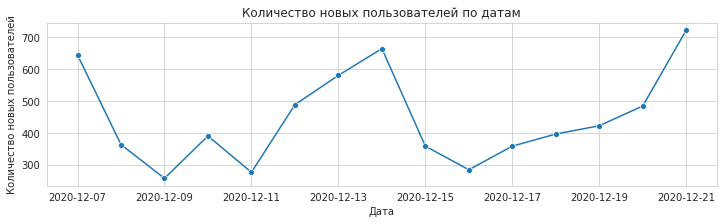

In [18]:
print('Всего пользователей:',
      new_users.query('user_id in @ab_users')['user_id'].nunique())

fig, ax = plt.subplots(figsize=(12,3))
sns.lineplot(data=new_users.query('user_id in @ab_users')
             .groupby('first_date', as_index=False).agg({'user_id':'count'}),
             x='first_date', y='user_id', marker='o')
plt.title('Количество новых пользователей по датам')
plt.xlabel('Дата')
plt.ylabel('Количество новых пользователей');

Согласно требованиям набор должен проходить с 2020-12-07 по 2020-12-12.  
Фактические даты набора совпадают с требованиями.  
Больше всего пользователей пришло в три дня: 12 июля, 14 и 21 декабря.

### Регион пользователей, доля от числа пользователей

Целевой регион пользователей - Европа.  
Посмотрю, из каких регионов пришли интересующие пользователи.

In [19]:
new_users.query('user_id in @ab_users').region.value_counts()

EU           6351
N.America     223
APAC           72
CIS            55
Name: region, dtype: int64

6351 пользователь относится к целевому региону.  
Оставшиеся 350 - нет. Удалю их из `ab_users`

In [20]:
users_to_delete = (new_users.query('user_id in @ab_users & region != "EU"')
                   ['user_id'].tolist())
print('Количество пользователей к удалению:', len(users_to_delete))

Количество пользователей к удалению: 350


In [21]:
ab_users = pd.DataFrame(ab_users, columns=['user_id'])
ab_users = ab_users[~ab_users['user_id'].isin(users_to_delete)]
print('Количество пользователей после очистки:', len(ab_users))

Количество пользователей после очистки: 6351


Ожидаемое количество пользователей, участвующих в тесте - это 15% от общего числа новых пользователей из целевого региона, зарегестрированных в период набора.  
Проверю, какой процент пользователей вошел в тест:

In [22]:
print('Процент пользователей, вошедших в тест:',
      len(ab_users) /
      len(new_users
          .query('first_date >= "2020-12-07" & first_date <= "2020-12-21" & region == "EU"'))
      * 100, '%')

Процент пользователей, вошедших в тест: 15.0 %


Это требование тоже выполняется.

### Участие в нескольких группах одновременно

Сначала проверю, есть ли среди интересуюших нас такие пользователи, которые участвуют и в других A/B-тестах

In [23]:
print('Количество пользователей, участвующих в нескольких тестах:',
      len(participants[participants['user_id'].isin(ab_users['user_id'])]
      .groupby('user_id').agg({'ab_test':'nunique'}).query('ab_test > 1')))

Количество пользователей, участвующих в нескольких тестах: 1602


Посмотрю, что это за тесты

In [24]:
participants[participants['user_id'].isin(ab_users['user_id'])]['ab_test'].unique().tolist()

['recommender_system_test', 'interface_eu_test']

Помимо исследуемого мной *recommender_system_test* - пользователи также принимали участие в тесте с новым интерфейсом.  
Так как поведение пользователей могло измениться из-за взаимодействия с новым интерфейсом, а не из-за системы рекомендаций - придется удалить пользователей из экспериментальных групп, которые участвовали в двух тестах сразу.

In [25]:
users_to_delete = ((participants[(participants['user_id'].isin(ab_users['user_id']))
                                  & (participants['group']=='B')]
                    .groupby('user_id').agg({'ab_test':'nunique'}).query('ab_test > 1'))
                    .index.tolist())

In [26]:
print('Кол-во удаленных пользователей:', len(users_to_delete))
ab_users = ab_users[~ab_users['user_id'].isin(users_to_delete)]

Кол-во удаленных пользователей: 344


Также проверю, нет ли в нашем тесте таких пользователей, которые участвуют сразу в двух группах.

In [27]:
print('Количество пользователей с более чем одной группой:',
      len(participants[participants['user_id'].isin(ab_users['user_id'])
                       & participants['ab_test'] == 'recommender_system_test']
          .groupby('user_id').agg({'group':'count'}).query('group > 1')))

Количество пользователей с более чем одной группой: 0


Все пользователи в исследовании относятся к одной группе.

### Равномерность распределения по группам

Снова посмотрю на набор пользователей по дням, но в этот раз по группам.  
Также посмотрю на итоговое количество пользователей в группах.

In [28]:
# добавлю информацию о группах теста
ab_users = (ab_users.merge(participants[(participants['user_id'].isin(ab_users['user_id']))
                                        & (participants['ab_test'] == 'recommender_system_test')]
                           [['user_id','group']],
                           on='user_id', how='left'))
# и о датах регистрации
ab_users = ab_users.merge(new_users, on='user_id', how='left')

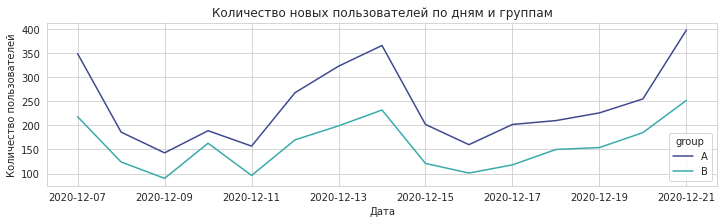

In [29]:
fig, ax = plt.subplots(figsize=(12,3))
sns.lineplot(data=ab_users.groupby(['first_date','group'],
                                   as_index=False).agg({'user_id':'count'}),
             x='first_date', y='user_id', hue='group', palette='mako')
plt.title('Количество новых пользователей по дням и группам')
plt.xlabel('Дата')
plt.ylabel('Количество пользователей');

In [30]:
ab_users.groupby('group').agg({'user_id':'nunique'})

,user_id
group,
A,3634
B,2373


Динамика набора пользователей для каждой группы одинакова, что повышает уверенность в результатах, которые будут получены в результате исследования.  
Однако распределение в группах неравное, группа B меньше примерно на 34%. Это важно иметь в виду.

### Вывод оценки корректности

Изначально для A/B-теста набран 6701 пользователь.  
350 из которых находятся не в целевом регионе (Европа) и были удалены.  
344 пользователя их экспериментальной группы участвало в конкурирующем тесте, связанном с изменениями интерфейса. Эти пользователи также были удалены из выборки.  
Пользователей с более одной группой не обнаружено.  
Динамика количества регистраций пользователей из групп схожа. В обеих группах наибольшее количество пользователей зарегестрировалось 14 и 21 декабря.  

## Изучение пользовательской активности

Отберу события по тем пользователям, которые нас интересуют, и буду изучать его.

In [31]:
ab_events = events[events['user_id'].isin(ab_users['user_id'])]

### Даты совершения событий, количество пользователей

По техническому требованию тест начался 2020-12-07 и должен был остановиться 2021-01-04.  
Посмотрю диапозон дат, по которым есть записи для участников теста.

In [32]:
print('Минимальная дата:', ab_events['event_dt'].min(),
      '\n' 'Максимальная дата', ab_events['event_dt'].max(),
      '\n' 'Максимальная дата в общем наборе', events['event_dt'].max())

Минимальная дата: 2020-12-07 00:05:57 
Максимальная дата 2020-12-30 12:42:57 
Максимальная дата в общем наборе 2020-12-30 23:36:33


Минимальная дата совпадает с моментом набора пользователей в группы.  
А вот максимальная как в общем наборе, так и в наборе с интересующими пользователями заканчивается 30 декабря.  
Тем не менее так как нас интересует эффект за 14 дней с момента регистрации - его можно расчитать и в пределах имеющихся событий.

Также посмотрю, сколько пользователей совершали какие-либо действия из набранных для теста.

In [33]:
print('Количество пользователей в тесте:', len(set(ab_users['user_id'])),
      '\n' 'Количество пользователей с событями:', len(set(ab_events['user_id'])))

Количество пользователей в тесте: 6007 
Количество пользователей с событями: 3375


Количество пользователей вновь сократилось, около 56% пользователей из набранных для A/B-теста не совершали никаких событий после регистрации.  
Эти пользователи не будут учитываться в анализе, так как по ним нет записей.  
Посмотрю на количество пользователей в группах из тех, записи о которых есть в `ab_events`. И сравню величины.

In [34]:
users_activity = (ab_users.groupby('group',as_index=False).agg({'user_id':'count'}).merge(
    ab_users[ab_users['user_id'].isin(ab_events['user_id'].unique())]
    .groupby('group', as_index=False).agg({'user_id':'count'}),
    on='group'))
users_activity.columns = ['group', 'users_cnt', 'active_users_cnt']
users_activity['change'] = (users_activity['active_users_cnt'] / users_activity['users_cnt'] - 1) * 100
users_activity

,group,users_cnt,active_users_cnt,change
0,A,3634,2604,-28.343423
1,B,2373,771,-67.509482


Активные пользователи из группы B составили всего 22% от всех активных пользователей.  
Количество активных пользователей в группе B снизилось на 67%, что гораздо больше снижения у группы A.

### Изучение неактивных пользователей

Выделю пользователей, которые не совершали никаких событий, и изучу их немного подробнее.

In [35]:
unactive_users = ab_users[~ab_users['user_id'].isin(ab_events['user_id'].unique())]
unactive_users.groupby('group').agg({'user_id':'nunique'})

,user_id
group,
A,1030
B,1602


Как уже известно - неактивных пользователей больше в группе B.  
Посмотрю на динамику набора неактивных пользователей.

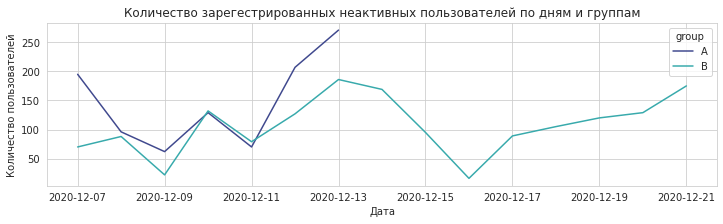

In [36]:
fig, ax = plt.subplots(figsize=(12,3))
sns.lineplot(data=unactive_users.groupby(['first_date','group'],
                                   as_index=False).agg({'user_id':'count'}),
             x='first_date', y='user_id', hue='group', palette='mako')
plt.title('Количество зарегестрированных неактивных пользователей по дням и группам')
plt.xlabel('Дата')
plt.ylabel('Количество пользователей');

Наибольшее количество неактивных пользователей в группе A и B зарегестрировалось 13 декабря - около 350 пользователей в A и 200 в B. Это почти все пользователи, зарегестрировавшиеся в этот день, если сравнивать с графиком регистраций (см пункт 3.4).  
Для группы A после этой даты неактивных пользователей не регистрировалось, а вот в группе B количество неактивных пользователей обычно находится в диапозоне от 50 до 150.

### Горизонт анализа: 14 дней с момента регистрации

Добавлю в набор данных с событиями номер группы пользователя и дату регистрации (`first_date`) из `ab_users`:

In [37]:
ab_events = ab_events.merge(ab_users[['user_id','group','first_date']],
                            on='user_id')

Расчитаю лайфтайм для событий в новом столбце.

In [38]:
ab_events['lifetime'] = pd.to_datetime(ab_events['event_dt'].dt.date) - ab_events['first_date']

И оставлю только те события, которые укладываются в 14-дневний лайфтайм.

In [39]:
ab_events = ab_events[ab_events['lifetime'] <= datetime.timedelta(days=14)]

### Первые события пользователей каждого вида

Посмотрю, в какой лайфтайм у пользователей впервые были совершены действия.  
Для этого сгруппирую пользователей по событям, найду первый лайфтайм.

In [40]:
users_lft_by_event = ab_events.groupby(['user_id', 'event_name'], as_index=False).agg({'lifetime':'first'})
# Лайфтайм приведу к дням, чтобы его можно было аггрегировать
users_lft_by_event['lifetime'] = users_lft_by_event['lifetime'].dt.days

Найду медиану, среднее, стандартное отклоение и максимум для лайфтаймов первых событий.

In [41]:
pd.DataFrame(users_lft_by_event.groupby(['user_id', 'event_name'], as_index=False)
             .agg({'lifetime':'first'}).groupby('event_name')['lifetime']
             .agg(['median','mean','std', 'max'])).style.background_gradient('GnBu')

,median,mean,std,max
event_name,,,,
login,0,0.014226,0.251481,8
product_cart,0,0.012048,0.214676,6
product_page,0,0.012299,0.239972,8
purchase,0,0.010456,0.197233,6


Большинство пользователей совершает каждое из событий втечение 24 часов после регистрации, так как медианна равна 0 и среднее значение не сильно выше нее. Стандартное отклонение самое высокое у события *login* и равно 0.28 дня, то есть первое событие авторизации разнится где-то на 6-7 часов для пользователей.  
Максимальные лайфтаймы для событий меньше четырнадцати дней и составляют 6 или 8 дней в зависимости от события.

### Вывод: соответствие теста техническим требованиям

Тест соответствует следующим техническим требованиям:  
- [x] В тесте участвуют 15% от новых пользователей из целевого региона  
- [x] Набор пользователей проходил в установленные сроки от 2020-12-07 до 2020-12-21
- [x] Данные о событиях располагают информацией, с которой можно рассчитать эффект в течение 14 дней после регистрации пользователей

Угроза искажения результатов анализа теста связана только с тем, что изначально пользователи были неравно распределены по группам. Также активных пользователей, записи о которых есть в `events`, оказалось меньше.  
Количество пользователей в обоих группах сократилось, но если в группе "A" только на 28%, то в группе "B" на 67%.  
В итоге группа "B" меньше группы "A" более чем в три раза. Малая численность группы "B" может исказить результаты теста.  

## Исследовательский анализ

### Распределение количества событий на пользователя

Для групп найду количество событий у каждого пользователя и построю гистограммы, где синим цветом отображаются гистограммы для группы A, а оранжевым для группы B.

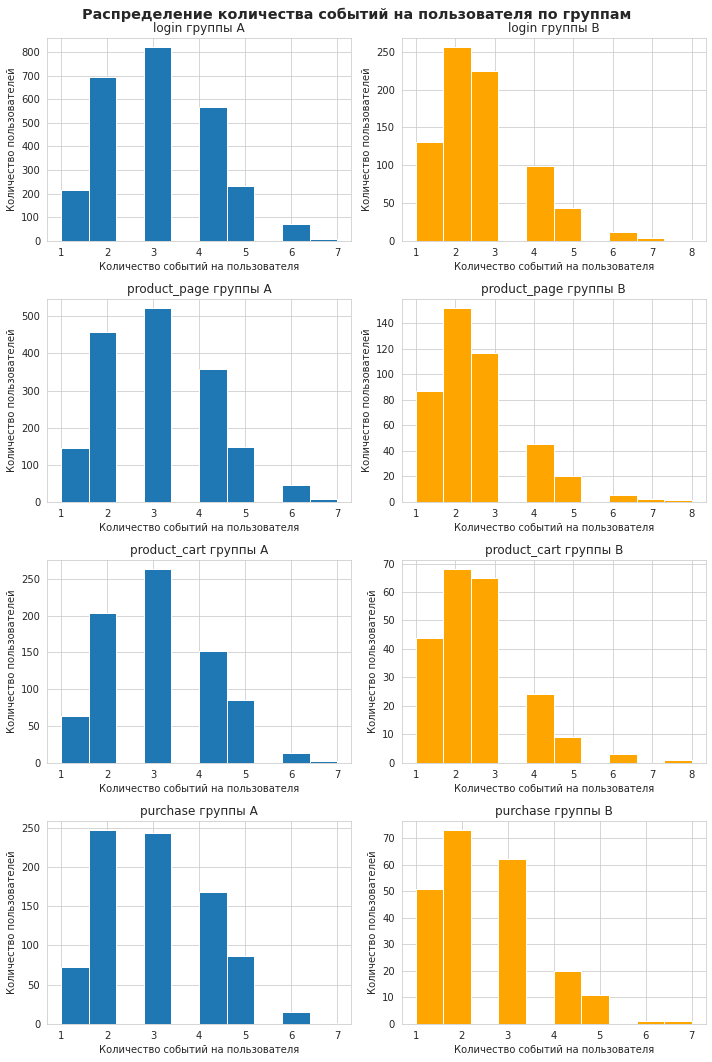

In [42]:
fig, axs = plt.subplots(nrows=4 , ncols= 2, figsize=(10, 15))
fig.suptitle('Распределение количества событий на пользователя по группам', size='x-large', fontweight='semibold')

for num, event in enumerate(['login','product_page','product_cart','purchase']):
    groupA = ab_events[ab_events['group'] == 'A']
    groupB = ab_events[ab_events['group'] == 'B']
    axs[num, 0].hist(groupA[groupA['event_name'] == event].groupby('user_id')['event_name'].count())
    axs[num, 1].hist(groupB[groupB['event_name'] == event].groupby('user_id')['event_name'].count(),
                     color='orange')
    axs[num, 0].set_title(event+' группы A')
    axs[num, 1].set_title(event+' группы B')
    axs[num, 0].set_xlabel('Количество событий на пользователя')
    axs[num, 1].set_xlabel('Количество событий на пользователя')
    axs[num, 0].set_ylabel('Количество пользователей')
    axs[num, 1].set_ylabel('Количество пользователей')

plt.tight_layout()

По гистограммам кажется, что пользователи из группы B реже пользовались приложением.  
В группе B на каждом из событий меньше тех, кто проходил его 4 и более раз.  
У группы A такхи пользователей больше. Чтобы убедиться в этом посмотрю на среднее количество событий на пользователя.

In [43]:
# Создам пустой датафрейм
events_count = pd.DataFrame(columns=['A','B'],
                            index=['login','product_page','product_cart','purchase'])
# Буду рассчитывать среднее кол-во событий на пользователей и добавлять в датафрейм
for event in events_count.index:
    groupA = ab_events[ab_events['group'] == 'A']
    groupB = ab_events[ab_events['group'] == 'B']
    groupA_mean = (groupA[groupA['event_name'] == event]
                   .groupby('user_id')['event_name'].count().mean())
    groupB_mean = (groupB[groupB['event_name'] == event]
                   .groupby('user_id')['event_name'].count().mean())
    events_count.at[event, 'A'] = groupA_mean
    events_count.at[event, 'B'] = groupB_mean

events_count

,A,B
login,3.059908,2.644156
product_page,3.041543,2.503497
product_cart,3.049872,2.53271
purchase,3.0,2.424658


Действительно, в группе B среднее количество событий на пользователя на каждом событии ниже, чем в группе A.  
Кажется, что пользователи группы B реже просматривают товары и делают заказы.    
Так как тест проводится на систему рекомендаций - возможно, это связано с тем, что группа B быстрее находит то, что ее интересует и сразу делает один заказ. То, насколько это выгодно для бизнеса - другой вопрос, который зависит в том числе от выручки и удовлетворения пользователя.

### Динамика количества событий в группах по дням, маркетинговые события

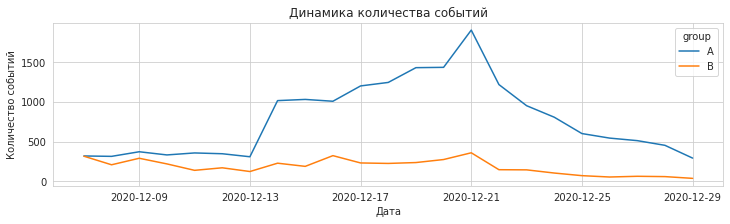

In [44]:
ab_events['event_date'] = ab_events['event_dt'].dt.date
fig, ax = plt.subplots(figsize=(12,3))
sns.lineplot(data=ab_events.groupby(['event_date','group'],as_index=False)
                           .agg({'event_name':'count'}),
             x='event_date', y='event_name', hue='group')
plt.title('Динамика количества событий')
plt.xlabel('Дата')
plt.ylabel('Количество событий');

Группа A совершает гораздо больше событий, 21 декабря заметен пик активности с 1400 событиями у группы A.  
Локальный пик в эту дату есть и у группы B.  
Но важно помнить, что группа A в принципе многочислена и больше группы B в три раза, что объясняет выраженные отличия.  
Проверю, нет ли совпадений между всплесками активности и маркетинговыми мероприятиями.

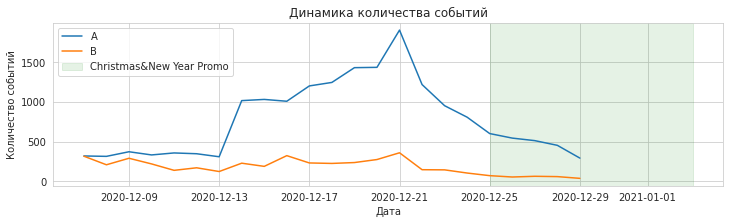

In [45]:
# Отберу события, которые проходят в целевой регионе и ограничу дату
eu_activities = calendar[calendar['regions'].str.contains('EU')].query('start_dt >= "2020-12-09"')

fig, ax = plt.subplots(figsize=(12,3))
sns.lineplot(data=ab_events.groupby(['event_date','group'],as_index=False)
                           .agg({'event_name':'count'}),
             x='event_date', y='event_name', hue='group')
plt.title('Динамика количества событий')
plt.xlabel('Дата')
plt.ylabel('Количество событий')

for index, row in eu_activities.iterrows():
    start_date = row['start_dt']
    end_date = row['finish_dt']
    activity_name = row['name']
#     Добавлю события на график
    plt.axvspan(start_date, end_date, alpha=0.1, color='green', label=activity_name)
    plt.legend()

На исследуемый период накладывается только одно событие - Новогоднее промо, и оно никак не отражается на активности пользователей.  
Скорее всего имеющийся пик связан с очищением до 14 лайфтайма.  
Больше всего пользователей было набрано 14 и 21 декабря (пункт 3.1).  
Видимо, вышло так, что 21 декабря те пользователи, которые зарегестрировались также залогинились и сделали покупку. К тому же пользователи, пришедшие ранее, могли к этому числу созреть и сделать заказ (есть пользователи, у которых лайфтайм событий равен 6-8 дням). Но большее влияние скорее оказали новые пользователи, пришедшие 21-о, ведь как мы помним, большинство клиентов совершает все события втечение 24 часов после регистрации.

### Продуктовая воронка

Наконец перейду к рассмотрению продуктовых воронок группы A и B.  
Сгруппирую `ab_events` по событиям и группам, также задам правильный порядок столбца с названием группы.

In [46]:
funnel = (ab_events.groupby(['event_name','group'], as_index=False)
          .agg({'user_id':'nunique'}))
funnel['event_name'] = funnel['event_name'].astype(pd.CategoricalDtype(
    categories=['login', 'product_page', 'product_cart', 'purchase'], ordered=True))

Определю функцию, которая посчитает долю пользователей от общего числа на событиях.

In [47]:
def churn_calc(row):
    """
    Функция построчно делит значение столбца user_id на кол-во уникальных пользователей
    в ab_events
    """
    if row['group'] == 'A':
        return (row['user_id']/
                ab_events[ab_events['group'] == 'A']['user_id'].nunique())
    elif row['group'] == 'B':
        return (row['user_id']/
                ab_events[ab_events['group'] == 'B']['user_id'].nunique())

И применю ее к `funnel`.

In [48]:
funnel['turn'] = funnel.apply(churn_calc, axis=1)

Визуализирую воронку событий на графике:

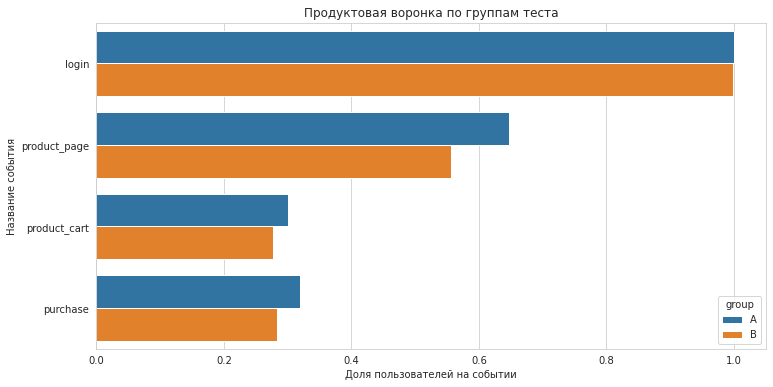

In [49]:
fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(data=funnel, y='event_name', x='turn', hue='group')
plt.title('Продуктовая воронка по группам теста')
plt.xlabel('Доля пользователей на событии')
plt.ylabel('Название события');

Ожидаемой конверсии по событиям не наблюдается. Группа B даже показывает худшую конверсию по сравнению с группой A.  
От логина до просмотра товаров в группе A дошло 64% пользователей, в группе B 55%.  
До корзины дошло 30% в A, 27% в B.  
И до покупки 31% в A и 28% в B.  
Любопытно также, что до покупки доходит больше пользователей, чем до корзины. Некоторые пользователи пропускают этот этап.  

Предварительно кажется, что группа B конвертируется хуже.  
Важно проверить также статистическую значимость получившихся разниц.

### Вывод исследовательского анализа

Среднее количество событий на пользователя в группе B ниже, чем в группе A.  
В группе A на каждом из шагов воронки больше таких пользователей, которые проходили его 4 и более раз.  

Наибольшее количество событий произошло с 14 по 22 декабря, где пик - 21 декабря.  
Пользователи из группы A совершили в ~4 раза больше событий по сравнению с группой B. Но стоит помнить, что группа B по количеству пользователей меньше в три раза.  
С 25 декабря началась промо-акция в честь Нового года и Рождества, но она не оказала влияния на активность пользователей, участвующих в тесте.  

Судя по продуктовой воронке - группа B не показывает повышения конверсии. Она в среднем меньше на 4%, а в событии *product_page* конверсия группы B ниже на 9% (64% у группы A против 55% у группы B)

## Статистическая проверка значимости

### Сравнение групп с помощью z-критерия

Статистическую значимость проверю с помощью z-критерия.  
Определю функцию, которая будет считать z-критерий и выводить результат проверки.  
Так как в тесте будет множественная проверка гипотез - применю поправку Бонферрони.

In [50]:
def z_value(total_users_A, total_users_B, step_amount_A, step_amount_B, num_tests, alpha_value=0.05, short=False):
    """
    Функция считает z-критерий для события в группах A и B, сравнивает p-value с альфа по умолчанию
    равному 0.05 и выводит результат статистической проверки
    """
    alpha = alpha_value / num_tests
    
    trials = np.array([total_users_A, total_users_B])
    successes = np.array([step_amount_A, step_amount_B])
    
    pA = successes[0]/trials[0] #Вероятность перехода в первой группе
    pB = successes[1]/trials[1] #Вероятность перехода во второй группе

    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
    difference = pA - pB
    
    # z-значение:
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
    distr = st.norm(0, 1)
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2 #Ищу p-value и умножаю на 2, так как тест двусторонний
    
    print('p-значение: ', p_value)
    if short==False:
        if p_value < alpha:
            print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
        else:
            print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
    else: pass

Теперь переберу события и с помощью z-критерия посмотрю, есть ли статистически значимая разница между группами A и B.

In [51]:
for event in ['login', 'product_page', 'product_cart', 'purchase']:
    print('Для', event)
    z_value(ab_events[ab_events['group'] == 'A']['user_id'].nunique(),
            ab_events[ab_events['group'] == 'B']['user_id'].nunique(),
            funnel.loc[(funnel['event_name'] == event) & (funnel['group'] == 'A'), 'user_id'].values[0],
            funnel.loc[(funnel['event_name'] == event) & (funnel['group'] == 'B'), 'user_id'].values[0],
            num_tests = 4)
    print('\n')

Для login
p-значение:  0.06605483265382306
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Для product_page
p-значение:  4.857760163901048e-06
Отвергаем нулевую гипотезу: между долями есть значимая разница


Для product_cart
p-значение:  0.22385510711753742
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Для purchase
p-значение:  0.05909125290474715
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными




Статистически значимые различия присутствуют только на событии просмотра товара (*product_page*).  
По вороне у группы B конверсия на этом этапе ниже на 6%.  
На остальных же этапах воронки существенных различий нет.  
В связи с такими результатами следует признать эксперимент провальным.  
Внедрение системы рекомендаций не повысило конверсию на ожидаемые 5%.  
Следует проверить корректность работы системы и выяснить причины, по которым конверсия в эксперементальной группе снизилась.  
Возможные причины:  
- неправильно настроенные рекомендации для пользователей  
- отвлечение внимания от процесса покупки  
- технические ошибки в интерфейсе и прочее  

Если проблемы будут обнаружены и устранены - лучше провести повторный тест, учесть недостатки текущего и набрать равное количество пользователей в группах.

### Вывод статистической проверки

Статистически значимые различия обнаружены только на событии просмотра товара (*product_page*).  
По вороне у группы B конверсия на этом этапе ниже на 6%.  
На остальных же этапах воронки существенных различий нет.  

p-value по гипотезе о равенстве конверсии между группами A и B по событиям:  
login: 0.066  
product_page: 0.00002  
product_cart: 0.223  
purchase: 0.059  

## Заключение

**Оценка корректности проведения теста**  
Изначально для A/B-теста набран 6701 пользователь.  
350 из которых находятся не в целевом регионе (Европа) и были удалены.  
344 пользователя участвуют также в конкурирующем тесте, связанном с изменениями интерфейса. Эти пользователи также были удалены из выборки.  
Пользователей с более одной группой не обнаружено.  
Динамика количества регистраций пользователей из групп схожа. В обеих группах наибольшее количество пользователей зарегестрировалось 14 и 21 декабря.  
Количество пользователей в группах на данном этапе:  
Группа A - 3634  
Группа B - 2373  

**Изучение пользовательской активности**  
Минимальная дата событий совпадает с моментом набора пользователей в группы.  
Максимальная дата событий заканчивается 30 декабря 2020. Завершение теста планировалось 4 января 2021.  
Тем не менее так как нас интересует эффект за 14 дней с момента регистрации - его можно расчитать и в пределах имеющихся событий.  

Из 6007 пользователей, зарегестрировавшихся и попавших в группы для тестирования, записи о событиях есть только по 3375 пользователям.  
56% пользователей не совершало никаких действий после регистрации.  
Количество пользователей в группах вновь снизилось:  
В группе "A": 2604  
В группе "B": 771  
Дисбаланс в количестве пользователей в группах усилился, группа B меньше контрольной более чем в три раза.  
Для событий был расчитан лайфтайм и для дальнейшего анализа события отфильтрованы до 14 лайфтайма, так как именно в течение 14 дней мы ожидаем получить результаты повышения конверсии.  
Изучены лайфтаймы по событиям:

In [52]:
pd.DataFrame(users_lft_by_event.groupby(['user_id', 'event_name'], as_index=False)
             .agg({'lifetime':'first'}).groupby('event_name')['lifetime']
             .agg(['median','mean','std', 'max'])).style.background_gradient('GnBu')

,median,mean,std,max
event_name,,,,
login,0,0.014226,0.251481,8
product_cart,0,0.012048,0.214676,6
product_page,0,0.012299,0.239972,8
purchase,0,0.010456,0.197233,6


Большинство пользователей совершает каждое из событий в течение 24 часов после регистрации, так как медианна равна 0 и среднее значение не сильно выше нее. Стандартное отклонение самое высокое у события login и равно 0.28 дня, то есть первое событие авторизации разнится где-то на 6-7 часов для пользователей.  
Максимальные лайфтаймы для событий меньше четырнадцати дней и составляют 6 или 8 дней в зависимости от события.  

Оценка соответствия теста техническим требованиям показала, что формальные требования выполняются.  
Однако есть угроза искажения достоверности результатов теста в связи с малым количеством пользователей в группе B по сравнению с группой A.  

**Исследовательский анализ**  
Среднее количество событий на пользователя в группе B ниже, чем в группе A.  
В группе A на каждом из шагов воронки больше таких пользователей, которые проходили его 4 и более раз.  

Наибольшее количество событий произошло с 14 по 22 декабря, где пик - 21 декабря.  
Пользователи из группы A совершили в ~4 раза больше событий по сравнению с группой B. Но стоит помнить, что группа B по количеству пользователей меньше в три раза.  
С 25 декабря началась промо-акция в честь Нового года и Рождества, но она не оказала влияния на активность пользователей, участвующих в тесте.  
Продуктовая воронка с процентом конверсии по этапам представлена на графике:

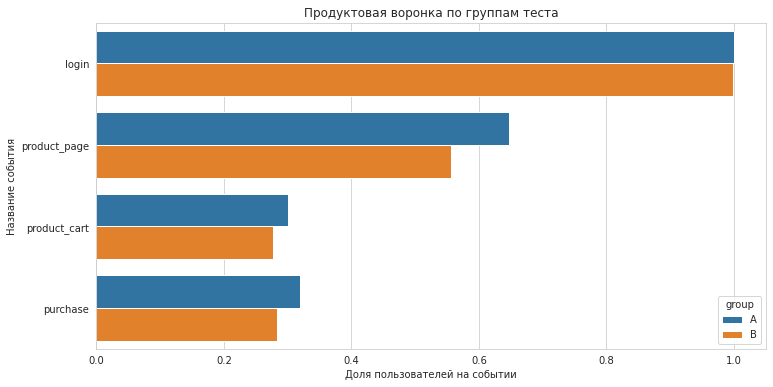

In [53]:
fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(data=funnel, y='event_name', x='turn', hue='group')
plt.title('Продуктовая воронка по группам теста')
plt.xlabel('Доля пользователей на событии')
plt.ylabel('Название события');

Судя по продуктовой воронке - группа B не показывает повышения конверсии. Она в среднем меньше на 4%, а в событии *product_page* конверсия группы B ниже на 9% (64% у группы A против 55% у группы B)

**Статистическая проверка гипотез**  
С применением z-критерия была оценена статистическая значимость разности показателей конверсии групп A и B на каждом из этапов продуктовой воронки.  
Статистически значимые различия присутствуют только на событии просмотра товара (product_page).  
По вороне у группы B конверсия на этом этапе ниже на 9%.  
На остальных же этапах воронки существенных различий нет.  

В связи с такими результатами следует признать эксперимент **провальным**.  
<br>Внедрение системы рекомендаций не повысило конверсию на ожидаемые 5%.  
Следует проверить корректность работы системы и выяснить причины, по которым конверсия в эксперементальной группе снизилась.  
Возможные причины:  
- неправильно настроенные рекомендации для пользователей
- отвлечение внимания от процесса покупки
- технические ошибки в интерфейсе и прочее

Если проблемы будут обнаружены и устранены - лучше провести повторный тест, учесть недостатки текущего и набрать равное количество пользователей в группах.